In [29]:
# Required Libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [30]:
# Load datasets
sector_22131000 = pd.read_csv('22131000_volume.csv', parse_dates=['RowKey']).set_index('RowKey')
future_data = pd.read_csv('future_data2.csv', parse_dates=['RowKey']).set_index('RowKey')
weather_data = pd.read_csv('weather_data_feature.csv', parse_dates=['datetime']).set_index('datetime')

In [31]:
sector_22132100 = pd.read_csv('22132100_volume.csv', parse_dates=['RowKey']).set_index('RowKey')
sector_22122000 = pd.read_csv('22122000_volume.csv', parse_dates=['RowKey']).set_index('RowKey')
sector_22121000= pd.read_csv('22121000_volume.csv', parse_dates=['RowKey']).set_index('RowKey')

In [32]:
#keep only date and remove time
sector_22131000.index = sector_22131000.index.date
future_data.index = future_data.index.date
weather_data.index = weather_data.index.date
sector_22132100.index = sector_22132100.index.date
sector_22122000.index = sector_22122000.index.date
sector_22121000.index = sector_22121000.index.date


In [35]:
#asfreq to fill missing dates
sector_22131000 = sector_22131000.asfreq('D')
sector_22132100 = sector_22132100.asfreq('D')
sector_22122000 = sector_22122000.asfreq('D')
sector_22121000 = sector_22121000.asfreq('D')

In [36]:
#fill missing values with interpolation linear  
sector_22131000 = sector_22131000.interpolate(method='linear')
sector_22132100 = sector_22132100.interpolate(method='linear')
sector_22122000 = sector_22122000.interpolate(method='linear')
sector_22121000 = sector_22121000.interpolate(method='linear')


INF_Value    0
dtype: int64

In [40]:
#merge sector data with weather data separately
sector_22131000 = sector_22131000.merge(weather_data, left_index=True, right_index=True)
sector_22132100 = sector_22132100.merge(weather_data, left_index=True, right_index=True)
sector_22122000 = sector_22122000.merge(weather_data, left_index=True, right_index=True)
sector_22121000 = sector_22121000.merge(weather_data, left_index=True, right_index=True)


In [41]:
sector_22131000

,INF_Value,precip_lag1,precip_lag2,precip_lag3,precip_lag4,precip_lag5,precip_lag6,precip_lag7,precip_rolling_sum,precip_rolling_mean,...,temp_lag1,temp_lag2,temp_lag3,humidity_lag1,humidity_lag2,humidity_lag3,temp_rolling_mean,temp_rolling_std,humidity_rolling_mean,humidity_rolling_std
2021-08-02,395.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,22.2,23.5,28.9,38.07,39.25,26.66,23.233333,0.929157,35.063333,6.257486
2021-08-03,446.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,24.0,22.2,23.5,27.87,38.07,39.25,24.000000,1.800000,33.696667,5.253012
2021-08-04,422.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,25.8,24.0,22.2,35.15,27.87,38.07,25.700000,1.652271,31.056667,3.723726
2021-08-05,436.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,27.3,25.8,24.0,30.15,35.15,27.87,27.166667,1.305118,30.343333,4.712975
2021-08-06,431.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,28.4,27.3,25.8,25.73,30.15,35.15,28.100000,0.700000,27.160000,2.590232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08,287.79,0.0,0.6,2.6,0.0,0.0,0.0,0.0,15.0,2.142857,...,11.0,10.8,8.9,86.54,90.65,94.91,10.866667,0.115470,90.433333,3.789648
2022-12-09,290.74,11.8,0.0,0.6,2.6,0.0,0.0,0.0,22.0,3.142857,...,10.8,11.0,10.8,94.11,86.54,90.65,10.933333,0.115470,90.433333,3.789648
2022-12-10,290.37,7.0,11.8,0.0,0.6,2.6,0.0,0.0,22.6,3.228571,...,11.0,10.8,11.0,90.65,94.11,86.54,10.766667,0.251661,90.673333,3.425060
2022-12-11,313.51,0.6,7.0,11.8,0.0,0.6,2.6,0.0,54.2,7.742857,...,10.5,11.0,10.8,87.26,90.65,94.11,11.166667,0.763763,89.646667,2.075628


In [42]:
#save all these data to csv
sector_22131000.to_csv('sector_22131000.csv')
sector_22132100.to_csv('sector_22132100.csv')
sector_22122000.to_csv('sector_22122000.csv')
sector_22121000.to_csv('sector_22121000.csv')

# sector 22131000

In [89]:
# Required Libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [92]:
sector_inter.columns

Index(['INF_Value', 'precip_lag1', 'precip_lag2', 'precip_lag3', 'precip_lag4',
       'precip_lag5', 'precip_lag6', 'precip_lag7', 'precip_rolling_sum',
       'precip_rolling_mean', 'precip_rolling_max', 'precip_rolling_min',
       'no_rain', 'light_rain', 'heavy_rain', 'days_since_last_rain',
       'accumulated_precip_30d', 'precip_change', 'temp_lag1', 'temp_lag2',
       'temp_lag3', 'humidity_lag1', 'humidity_lag2', 'humidity_lag3',
       'temp_rolling_mean', 'temp_rolling_std', 'humidity_rolling_mean',
       'humidity_rolling_std'],
      dtype='object')

In [91]:
# Load datasets
sector_inter = pd.read_csv('sector_22131000_interpolated.csv', parse_dates=['Unnamed: 0']).set_index('Unnamed: 0')
future_data = pd.read_csv('future_data2.csv', parse_dates=['RowKey']).set_index('RowKey')

In [93]:
sector_inter.index.names = ['RowKey']

<Axes: xlabel='RowKey'>

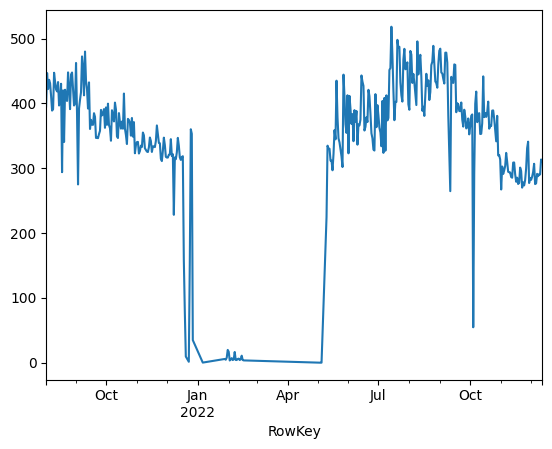

In [94]:
#plot INF_Value
sector_inter['INF_Value'].plot()

In [95]:

# Splitting the data
train, valid = train_test_split(sector_inter, test_size=0.2, shuffle=False)
test = future_data

In [96]:

# Drop INF_Value for XGBoost training and validation
X_train = train.drop('INF_Value', axis=1)
y_train = train['INF_Value']
X_valid = valid.drop('INF_Value', axis=1)
y_valid = valid['INF_Value']
X_test = test.drop('INF_Value', axis=1)

In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define the range of orders and seasonal orders to search through
p_values = [0, 1, 2]  # AutoRegressive order (p)
d_values = [0, 1]     # Differencing order (d)
q_values = [0, 1, 2]  # Moving Average order (q)
seasonal_periods = [7, 30, 13, 12]  # Different seasonal periods to try

best_aic = float("inf")
best_order = (0, 0, 0)
best_seasonal_order = (0, 0, 0, 0)

# Iterate through all possible combinations
for p in p_values:
    for d in d_values:
        for q in q_values:
            for seasonal_period in seasonal_periods:
                order = (p, d, q)
                seasonal_order = (p, d, q, seasonal_period)
                
                # Fit the SARIMA model with the current order and seasonal order
                sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
                sarima_result = sarima_model.fit(disp=False)
                
                # Calculate AIC (Akaike Information Criterion)
                current_aic = sarima_result.aic
                
                # Update the best order if the current AIC is lower
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = order
                    best_seasonal_order = seasonal_order

# Print the best SARIMA order and seasonal order
print("Best SARIMA Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)

C:\Users\lalit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\lalit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\lalit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\lalit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCac

Best SARIMA Order: (2, 1, 2)
Best Seasonal Order: (2, 1, 2, 30)


In [97]:

# Fit the SARIMA model with the best order and seasonal order
best_sarima_model = SARIMAX(y_train, order=best_order, seasonal_order=best_seasonal_order)
best_sarima_result = best_sarima_model.fit(disp=False)

# SARIMA predictions with the best orders
sarima_predictions = best_sarima_result.predict(start=y_train.index[-1], end=y_valid.index[-1], dynamic=True)
future_sarima_predictions = best_sarima_result.predict(start=y_valid.index[-1], end=test.index[-1], dynamic=True)
# Fit the SARIMA model with the best order and seasonal order
best_sarima_model = SARIMAX(y_train, order=best_order, seasonal_order=best_seasonal_order)
best_sarima_result = best_sarima_model.fit(disp=False)

# SARIMA predictions with the best orders
sarima_predictions = best_sarima_result.predict(start=y_train.index[-1], end=y_valid.index[-1], dynamic=True)
future_sarima_predictions = best_sarima_result.predict(start=y_valid.index[-1], end=test.index[-1], dynamic=True)
sarima_predictions = abs(sarima_predictions)
future_sarima_predictions = abs(future_sarima_predictions)

C:\Users\lalit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\lalit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\lalit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lalit\AppData\Local\Packages\PythonSoftwar

In [88]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200]
}

# Create the XGBoost model
xgb_model = XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)



Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}


ValueError: feature_names mismatch: ['precip_lag1', 'precip_lag2', 'precip_lag3', 'precip_lag4', 'precip_lag5', 'precip_lag6', 'precip_lag7', 'precip_rolling_sum', 'precip_rolling_mean', 'precip_rolling_max', 'precip_rolling_min', 'no_rain', 'light_rain', 'heavy_rain', 'days_since_last_rain', 'accumulated_precip_30d', 'precip_change', 'temp_lag1', 'temp_lag2', 'temp_lag3', 'humidity_lag1', 'humidity_lag2', 'humidity_lag3', 'temp_rolling_mean', 'temp_rolling_std', 'humidity_rolling_mean', 'humidity_rolling_std', 'INF_Value_Interpolated'] ['precip_lag1', 'precip_lag2', 'precip_lag3', 'precip_lag4', 'precip_lag5', 'precip_lag6', 'precip_lag7', 'precip_rolling_sum', 'precip_rolling_mean', 'precip_rolling_max', 'precip_rolling_min', 'no_rain', 'light_rain', 'heavy_rain', 'days_since_last_rain', 'accumulated_precip_30d', 'precip_change', 'temp_lag1', 'temp_lag2', 'temp_lag3', 'humidity_lag1', 'humidity_lag2', 'humidity_lag3', 'temp_rolling_mean', 'temp_rolling_std', 'humidity_rolling_mean', 'humidity_rolling_std']
expected INF_Value_Interpolated in input data

In [98]:
# Train a new XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# XGBoost predictions with the best hyperparameters
xgb_predictions = best_xgb_model.predict(X_valid)
future_xgb_predictions = best_xgb_model.predict(X_test)
# XGBoost predictions with the best hyperparameters
xgb_predictions = best_xgb_model.predict(X_valid)
future_xgb_predictions = best_xgb_model.predict(X_test)
# Convert xgb_predictions to a pandas Series with a datetime index
xgb_predictions_series = pd.Series(xgb_predictions, index=y_valid.index)
future_xgb_predictions_series = pd.Series(future_xgb_predictions, index=test.index)

In [118]:

future_ensemble_predictions = 0.28 * future_sarima_predictions + 0.72 * future_xgb_predictions_series

# Ensemble Predictions
ensemble_predictions = 0.28 * sarima_predictions + 0.72 * xgb_predictions_series

In [119]:
# Create DataFrame for Test and Future Predictions
predictions_df = pd.DataFrame({
    'Actual': y_valid,
    'SARIMA_Predictions': sarima_predictions,
    'XGBoost_Predictions': xgb_predictions_series,
    'Ensemble_Predictions': ensemble_predictions
}, index=y_valid.index)

future_predictions_df = pd.DataFrame({
    'SARIMA_Future_Predictions': future_sarima_predictions,
    'XGBoost_Future_Predictions': future_xgb_predictions_series,
    'Ensemble_Future_Predictions': future_ensemble_predictions
}, index=test.index)

In [121]:


import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual values
actual_values = predictions_df['Actual']

# SARIMA predictions
sarima_predictions = predictions_df['SARIMA_Predictions']

# XGBoost predictions
xgboost_predictions = predictions_df['XGBoost_Predictions']

# Ensemble predictions
ensemble_predictions = predictions_df['Ensemble_Predictions']

# Calculate MAPE for each method
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

mape_sarima = mape(actual_values, sarima_predictions)
mape_xgboost = mape(actual_values, xgboost_predictions)
mape_ensemble = mape(actual_values, ensemble_predictions)

# Calculate RMSE for each method
rmse_sarima = np.sqrt(mean_squared_error(actual_values, sarima_predictions))
rmse_xgboost = np.sqrt(mean_squared_error(actual_values, xgboost_predictions))
rmse_ensemble = np.sqrt(mean_squared_error(actual_values, ensemble_predictions))

# Calculate MAE for each method
mae_sarima = mean_absolute_error(actual_values, sarima_predictions)
mae_xgboost = mean_absolute_error(actual_values, xgboost_predictions)
mae_ensemble = mean_absolute_error(actual_values, ensemble_predictions)

# Display the results
print("SARIMA MAPE:", mape_sarima)
print("XGBoost MAPE:", mape_xgboost)
print("Ensemble MAPE:", mape_ensemble)

print("SARIMA RMSE:", rmse_sarima)
print("XGBoost RMSE:", rmse_xgboost)
print("Ensemble RMSE:", rmse_ensemble)

print("SARIMA MAE:", mae_sarima)
print("XGBoost MAE:", mae_xgboost)
print("Ensemble MAE:", mae_ensemble)
future_predictions_df
predictions_df

SARIMA MAPE: 109.13457921032854
XGBoost MAPE: 39.49779821610026
Ensemble MAPE: 20.392071561808084
SARIMA RMSE: 360.07060443656775
XGBoost RMSE: 143.65096635899357
Ensemble RMSE: 70.09383037974055
SARIMA MAE: 320.18903655905507
XGBoost MAE: 110.94317248792647
Ensemble MAE: 51.73808229701468


,Actual,SARIMA_Predictions,XGBoost_Predictions,Ensemble_Predictions
RowKey,,,,
2022-09-04,437.76,457.239511,431.644257,438.810938
2022-09-05,430.65,478.082478,415.620697,433.110012
2022-09-06,478.24,484.658168,391.773773,417.781405
2022-09-07,478.26,506.762780,413.853424,439.868066
2022-09-08,463.00,528.200455,442.443939,466.455789
...,...,...,...,...
2022-12-08,287.79,870.488137,49.749733,279.556487
2022-12-09,290.74,902.675941,3.976748,255.612522
2022-12-10,290.37,901.228410,52.252609,289.965834


In [122]:
future_predictions_df

,SARIMA_Future_Predictions,XGBoost_Future_Predictions,Ensemble_Future_Predictions
RowKey,,,
2022-12-13,891.964080,102.637749,323.649128
2022-12-14,871.780087,68.005890,293.062665
2022-12-15,893.690070,46.470955,283.692307
2022-12-16,928.796713,93.980927,327.729347
2022-12-17,925.985039,78.459457,315.766621
2022-12-18,933.299479,76.714813,316.558523
2022-12-19,915.719003,98.717499,327.477920


In [117]:
#mean of actual values
mean = predictions_df['Actual'].mean()
mean

342.8701500000001

In [102]:
predictions_df.head(50)

,Actual,SARIMA_Predictions,XGBoost_Predictions,Ensemble_Predictions
RowKey,,,,
2022-09-04,437.760,457.239511,431.644257,449.560944
2022-09-05,430.650,478.082478,415.620697,459.343945
2022-09-06,478.240,484.658168,391.773773,456.792853
2022-09-07,478.260,506.762780,413.853424,478.889974
2022-09-08,463.000,528.200455,442.443939,502.473503
2022-09-09,381.000,526.401307,442.197968,501.140308
2022-09-10,322.825,537.647915,457.359833,513.561502
2022-09-11,264.650,531.913792,459.009308,510.042459
2022-09-12,440.990,562.723430,465.927704,533.684721
